# Batch correction results and cell markers


## Algorithms and parameters

From the benchmarks with Harmony, scVI, SingleR and OnClass the results showed how the combination of scVI + SingleR outperformed the other methods:


<img src="./figures/scPOP_results.png" style="width:30%"> 

From this method, the best combination of parameter was (UPDATE WITH NEW RESULTS):
- 2000 Highly variable genes
- 40 dimensions of latent space
- 5 knn when computing the neighbors graph


Next analysis and data integration changed the parameters.

## Umap and celltypes

To transfer the umaps from the latent space model to my dataset I am going to compute the umap to the model and then copy the resulting coordinates in my dataset. Then I'll plot some cell types and check if the markers are leiable or not in order to decide if some refiniment are needed or not.


In [1]:
# prepare environmnet
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))

In [2]:
adata = sc.read("Data/MM_atlas_raw_labelled.h5ad") # load dataset
latent = sc.read("Data/MM_atlas_raw_labelled_tmp_2000_40_latent.h5ad") # load latent space representation

Compute umap on latent representation using 25 as knn parameter, then plot the dataset with the cell labels

In [3]:
sc.pp.neighbors(latent, n_neighbors=25)
sc.tl.umap(latent)

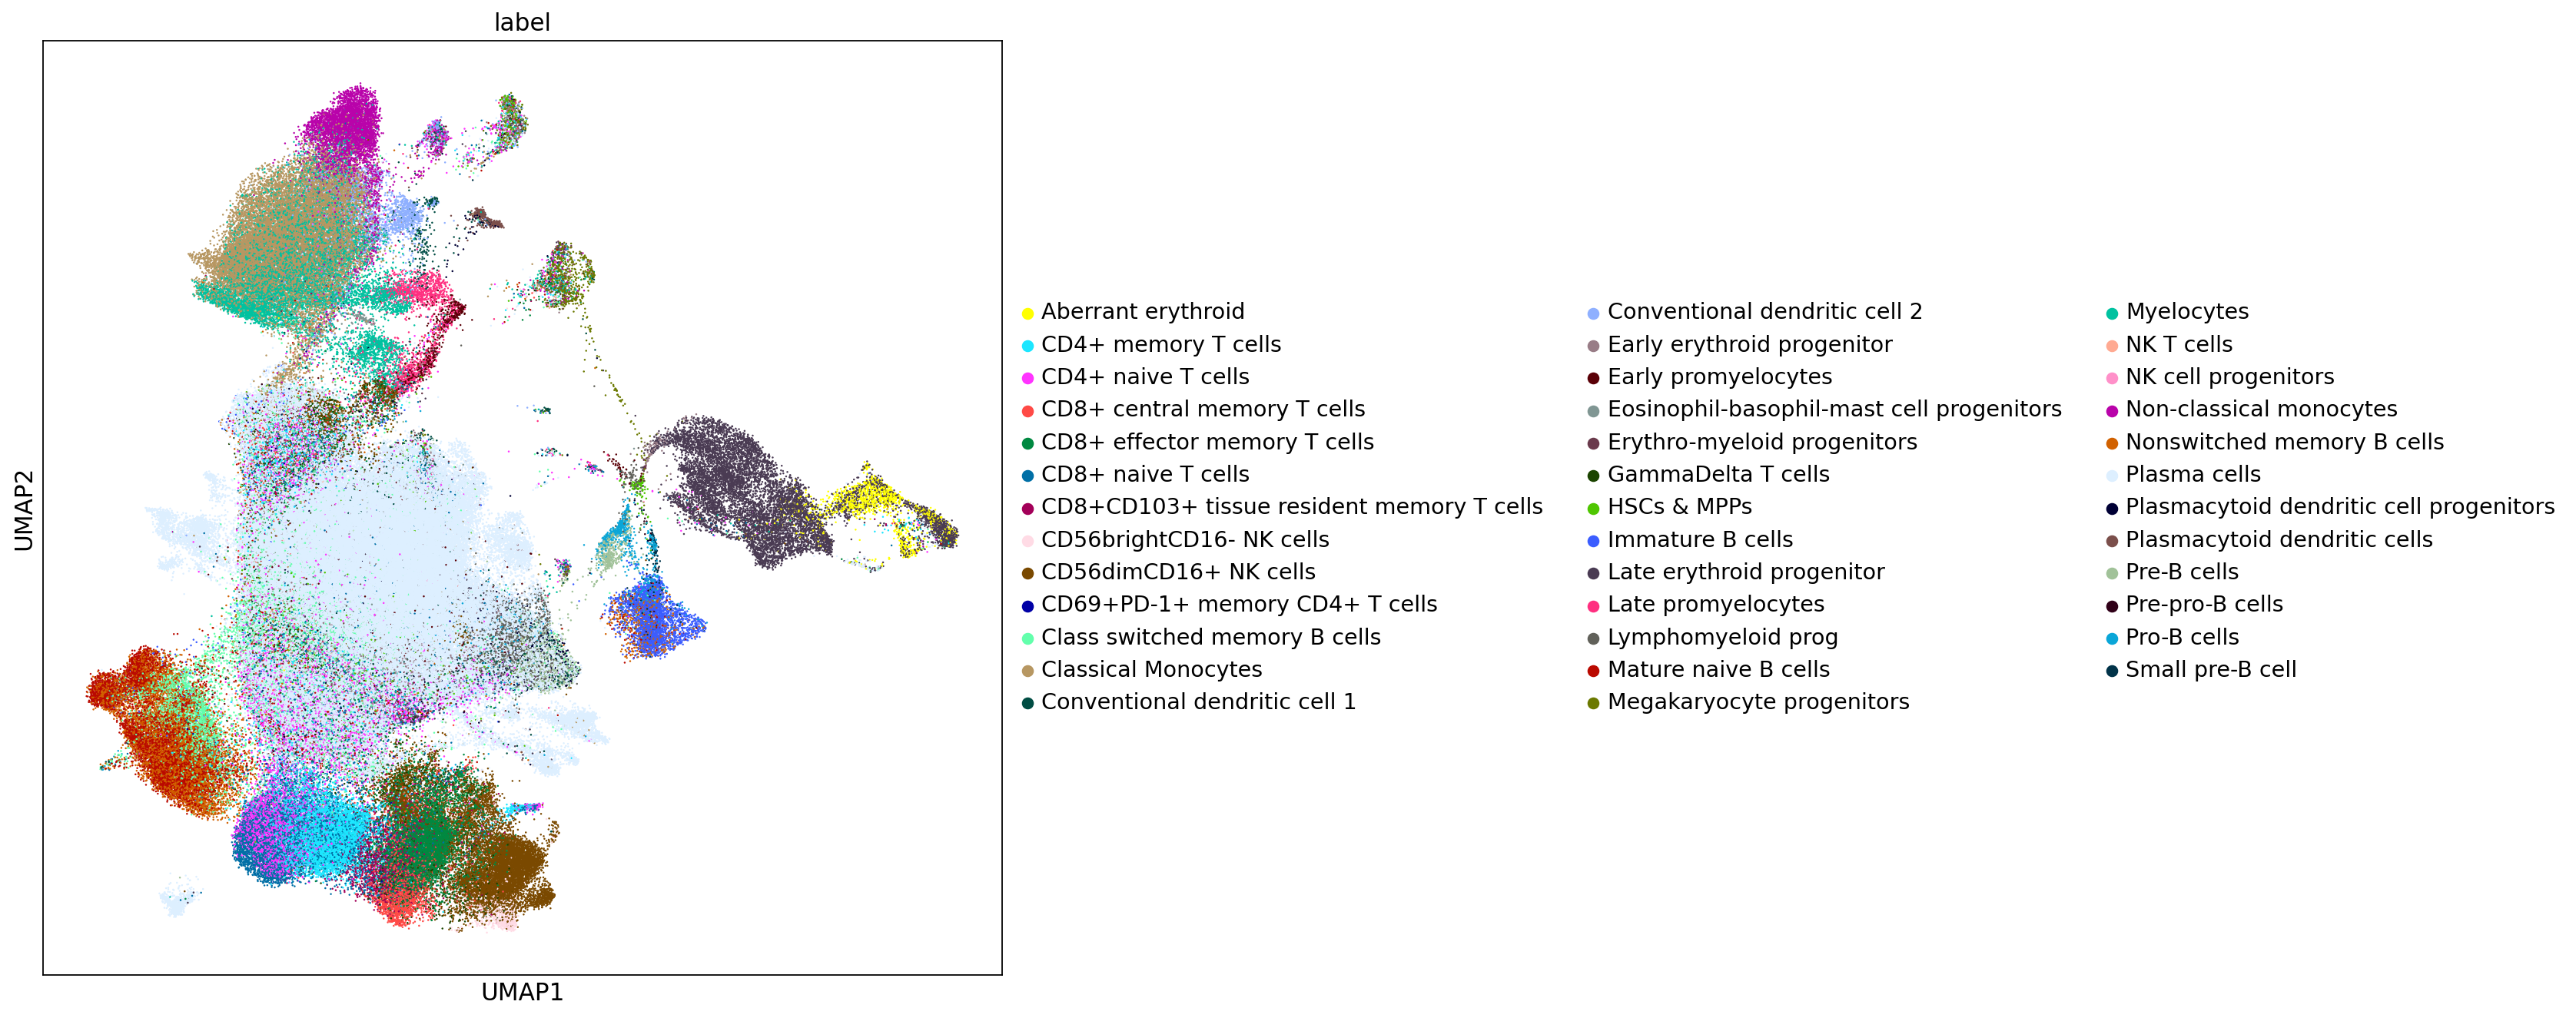

In [4]:
sc.pl.umap(latent, color="label", size=5, save="_celltypes.png")

In [5]:
latent

AnnData object with n_obs × n_vars = 297808 × 40
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'RNA_snn_res.0.2', 'seurat_clusters', 'label', 'ident', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap', 'label_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [6]:
adata.uns = latent.uns
adata.obsm = latent.obsm
adata.obsp = latent.obsp

In [7]:
adata.write("Data/MM_atlas_umap.h5ad")

In [8]:
def plot_cells(cells, label_column, name):
    #cells.append("Not selected")
    myvector = adata.obs[label_column]
    myvector = myvector.cat.set_categories(new_categories=cells)
    #myvector = myvector.fillna("Not selected")
    adata.obs["selected_cells"] = myvector
    #print(adata.obs["selected_cells"])
    sc.pl.umap(adata, color = "selected_cells", size=5, save=name)

## NK cells

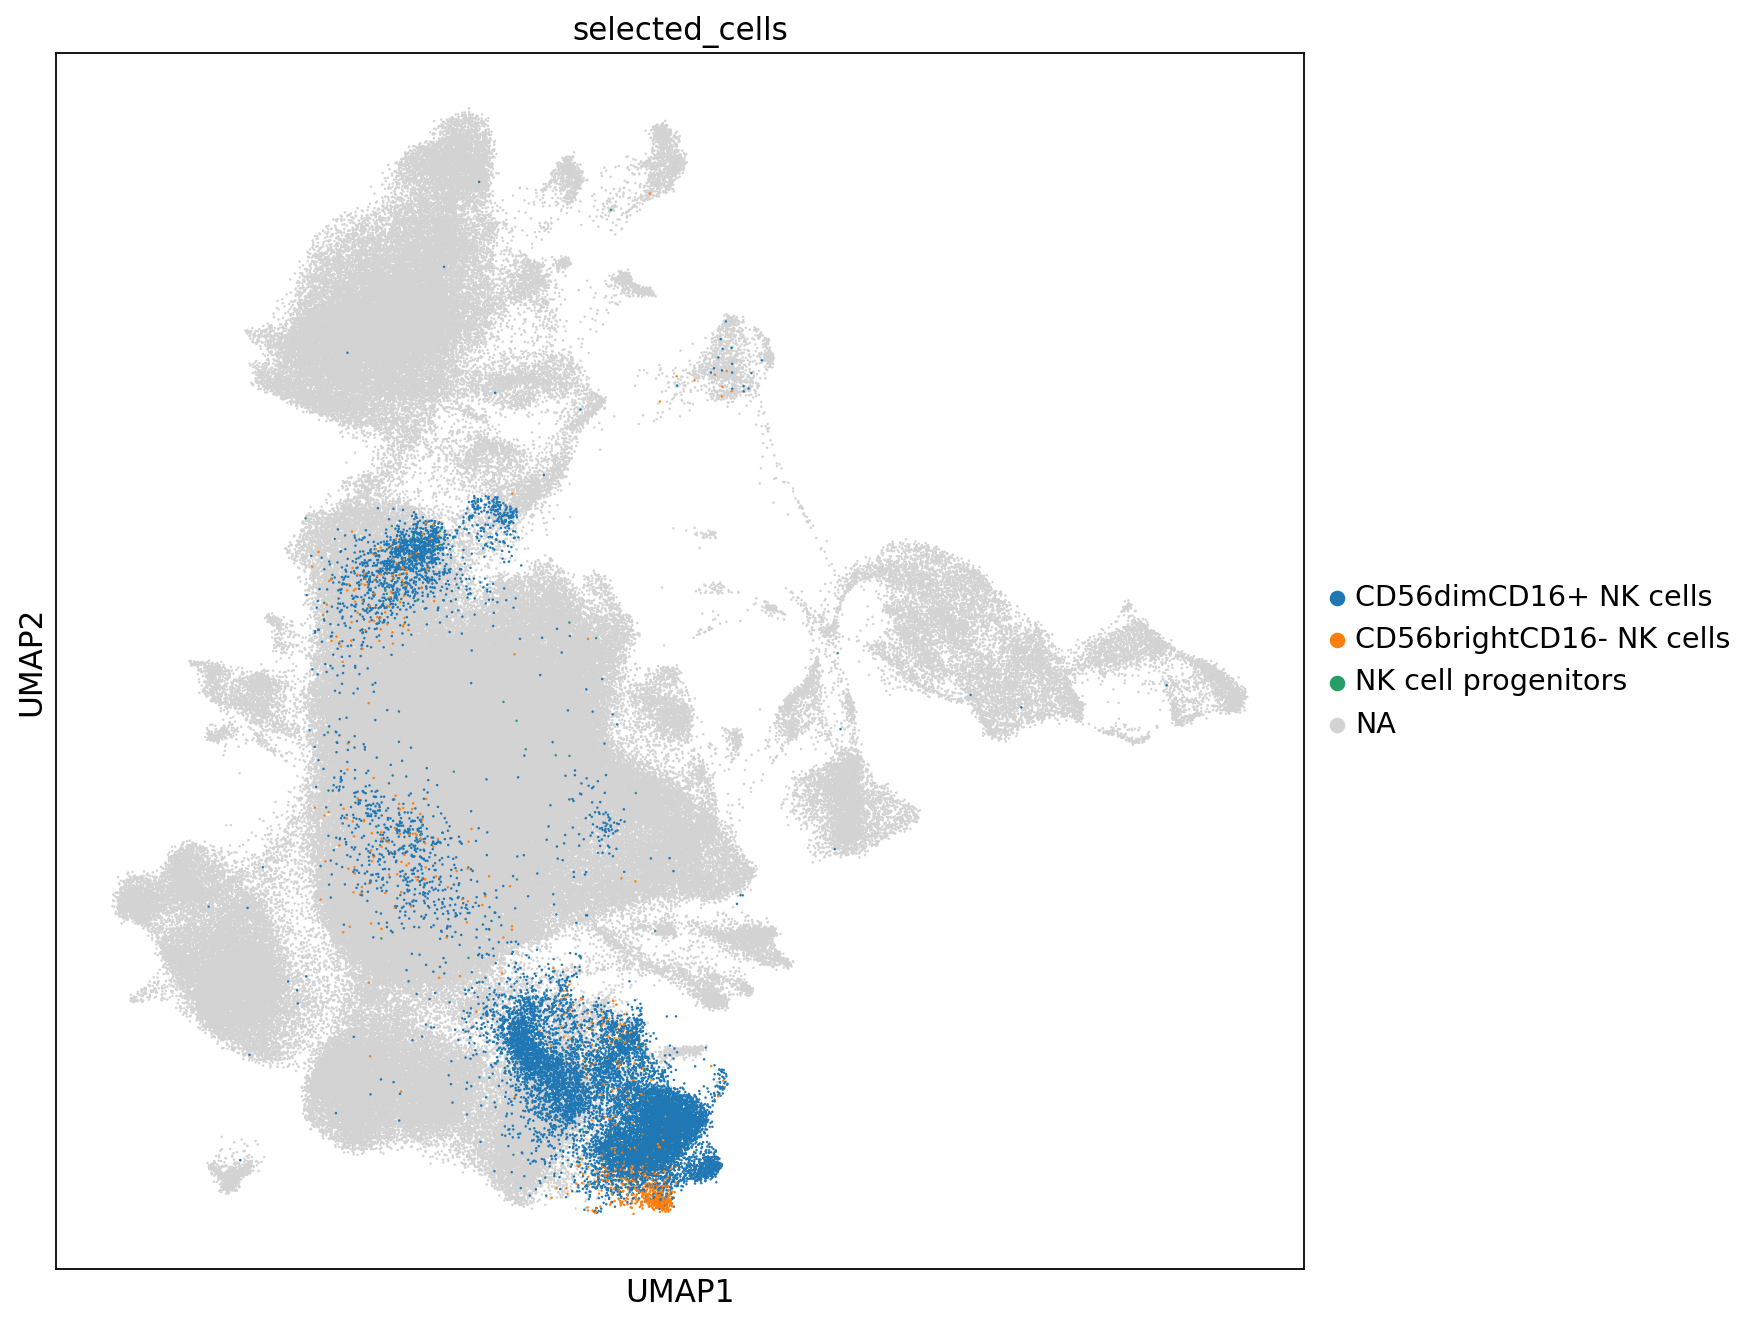

In [9]:
cells = ["CD56dimCD16+ NK cells", "CD56brightCD16- NK cells", "NK cell progenitors"]
plot_cells(cells, "label", "NK.png")

## Pre B cells to Plasma cells

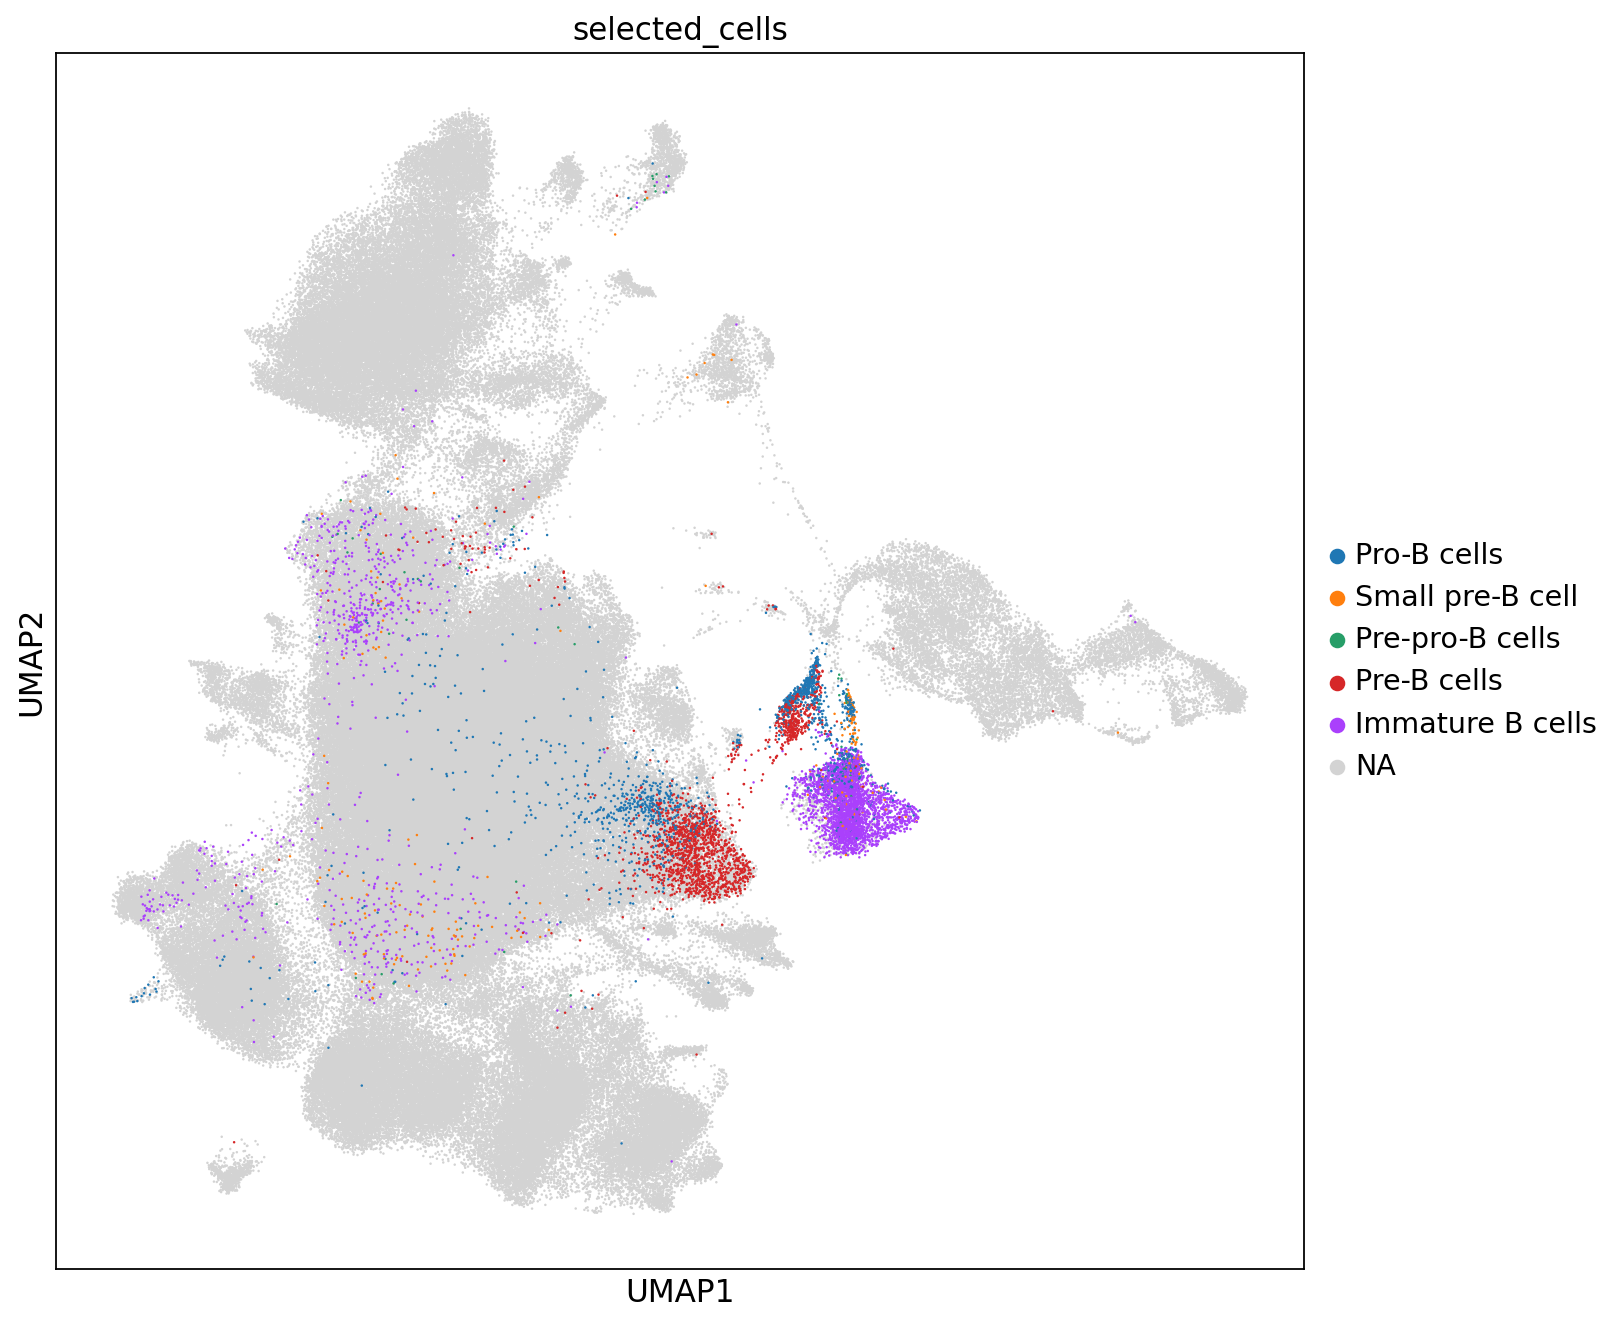

In [10]:
cells = ["Pro-B cells", "Small pre-B cell", "Pre-pro-B cells", "Pre-B cells", "Immature B cells"]
plot_cells(cells, "label", "pre-B.png")

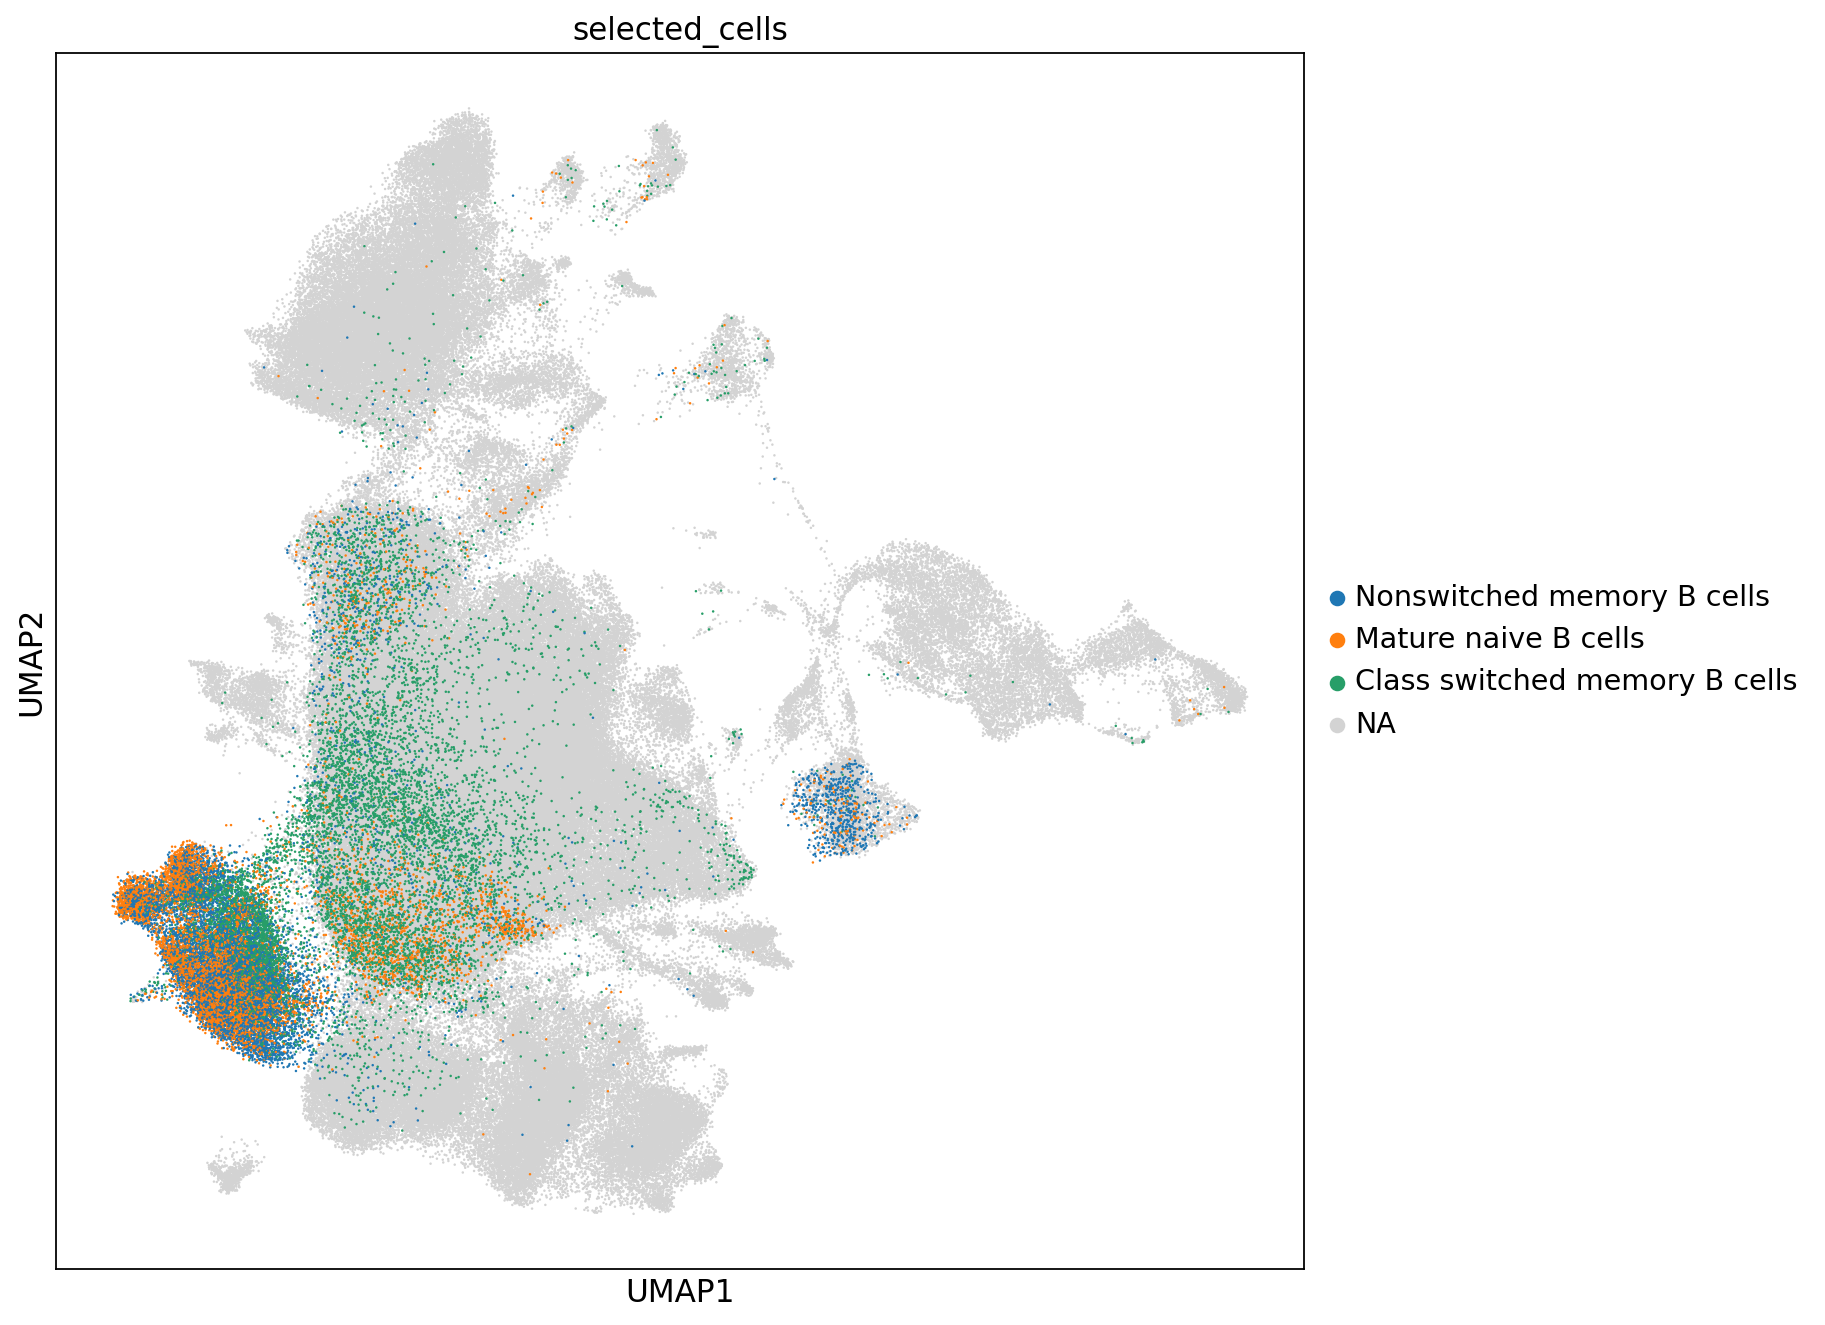

In [20]:
cells = ["Nonswitched memory B cells", "Mature naive B cells", "Class switched memory B cells"]
plot_cells(cells, "label", "B.png")

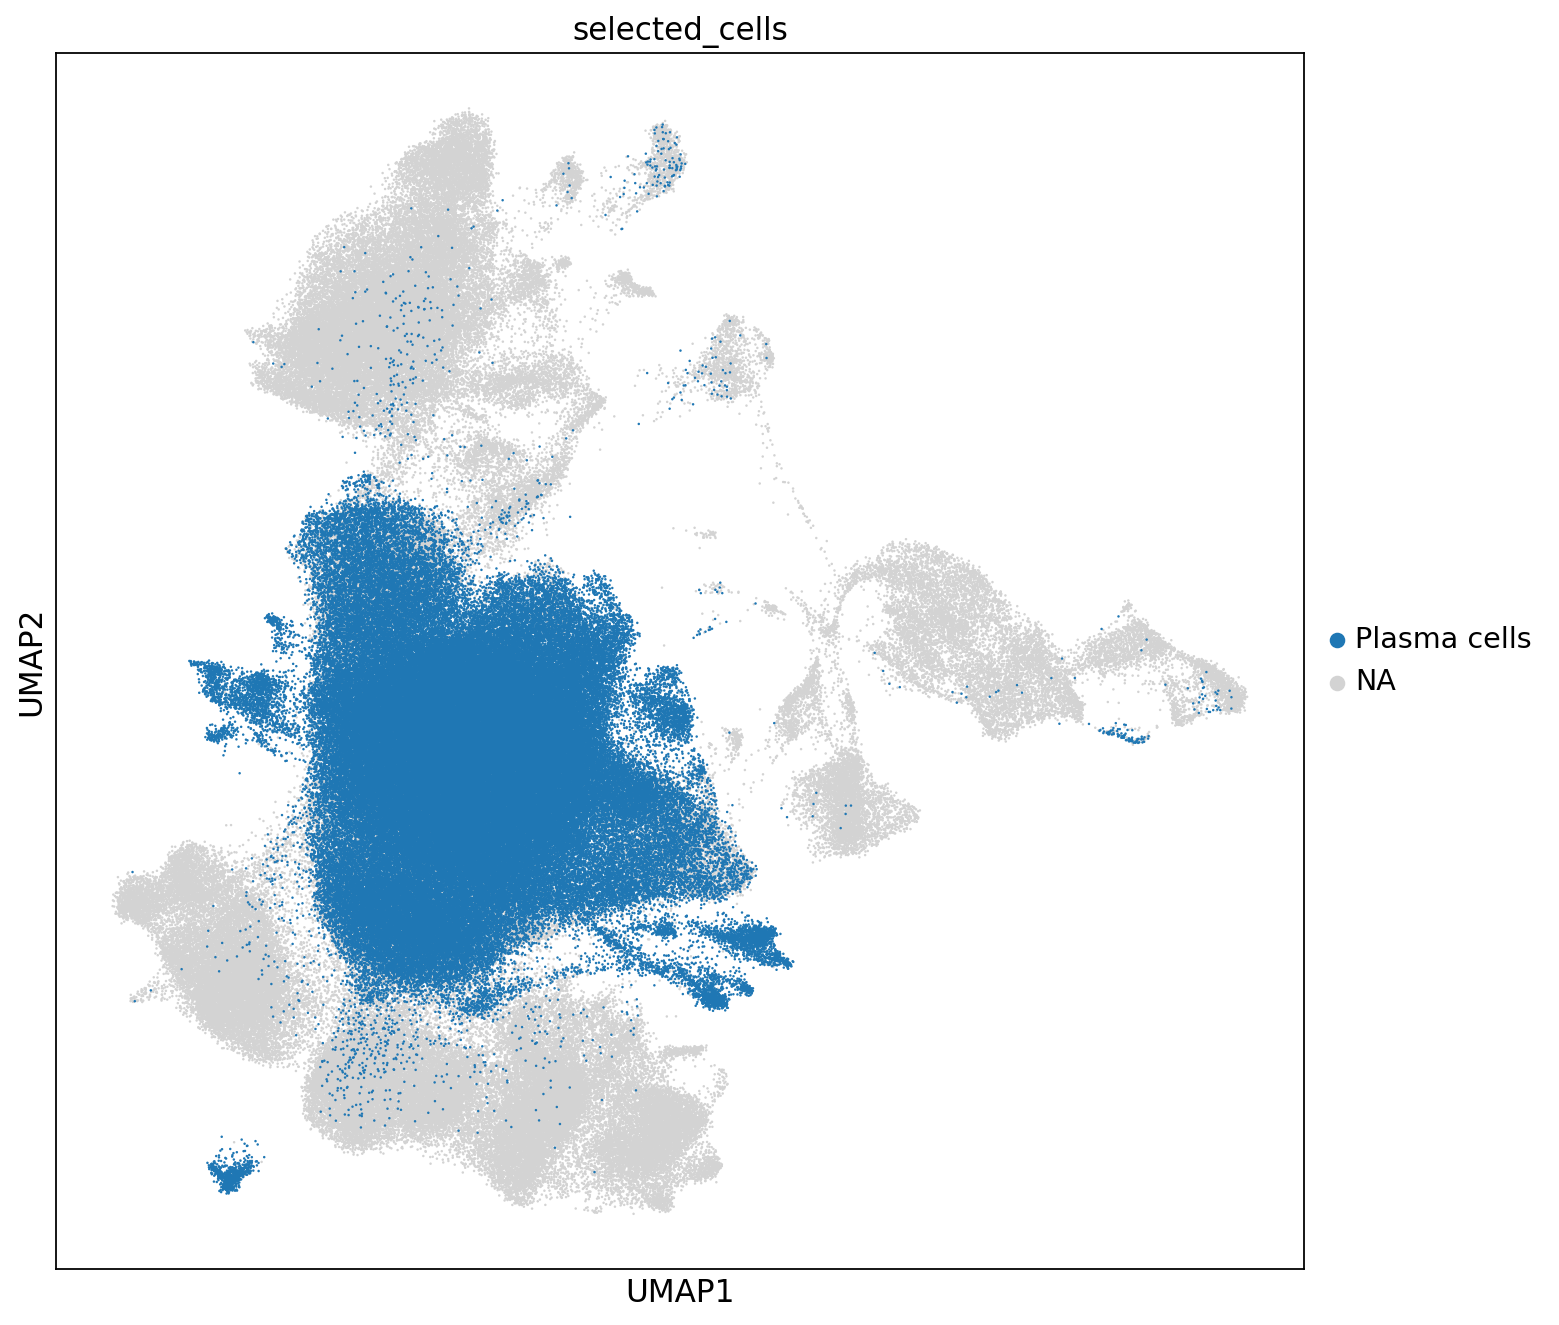

In [12]:
cells = ["Plasma cells"]
plot_cells(cells, "label", "Plasma.png")

## Marker genes

### Pre-processing:
- remove genes expressed in less than 3 cells (1/10 of the least numerous cell type: NK cell progenitors 31)
- normalize cell by total counts over all genes, so that every cell has the same total count after normalization ($10^4$ factor is selected since most of the samples were filtered by values of this order)
- logaritmize counts


In [13]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [14]:
sc.tl.rank_genes_groups(adata, 'label', method='logreg')

/home/jacopo/miniconda3/envs/scanpy_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### NK cells

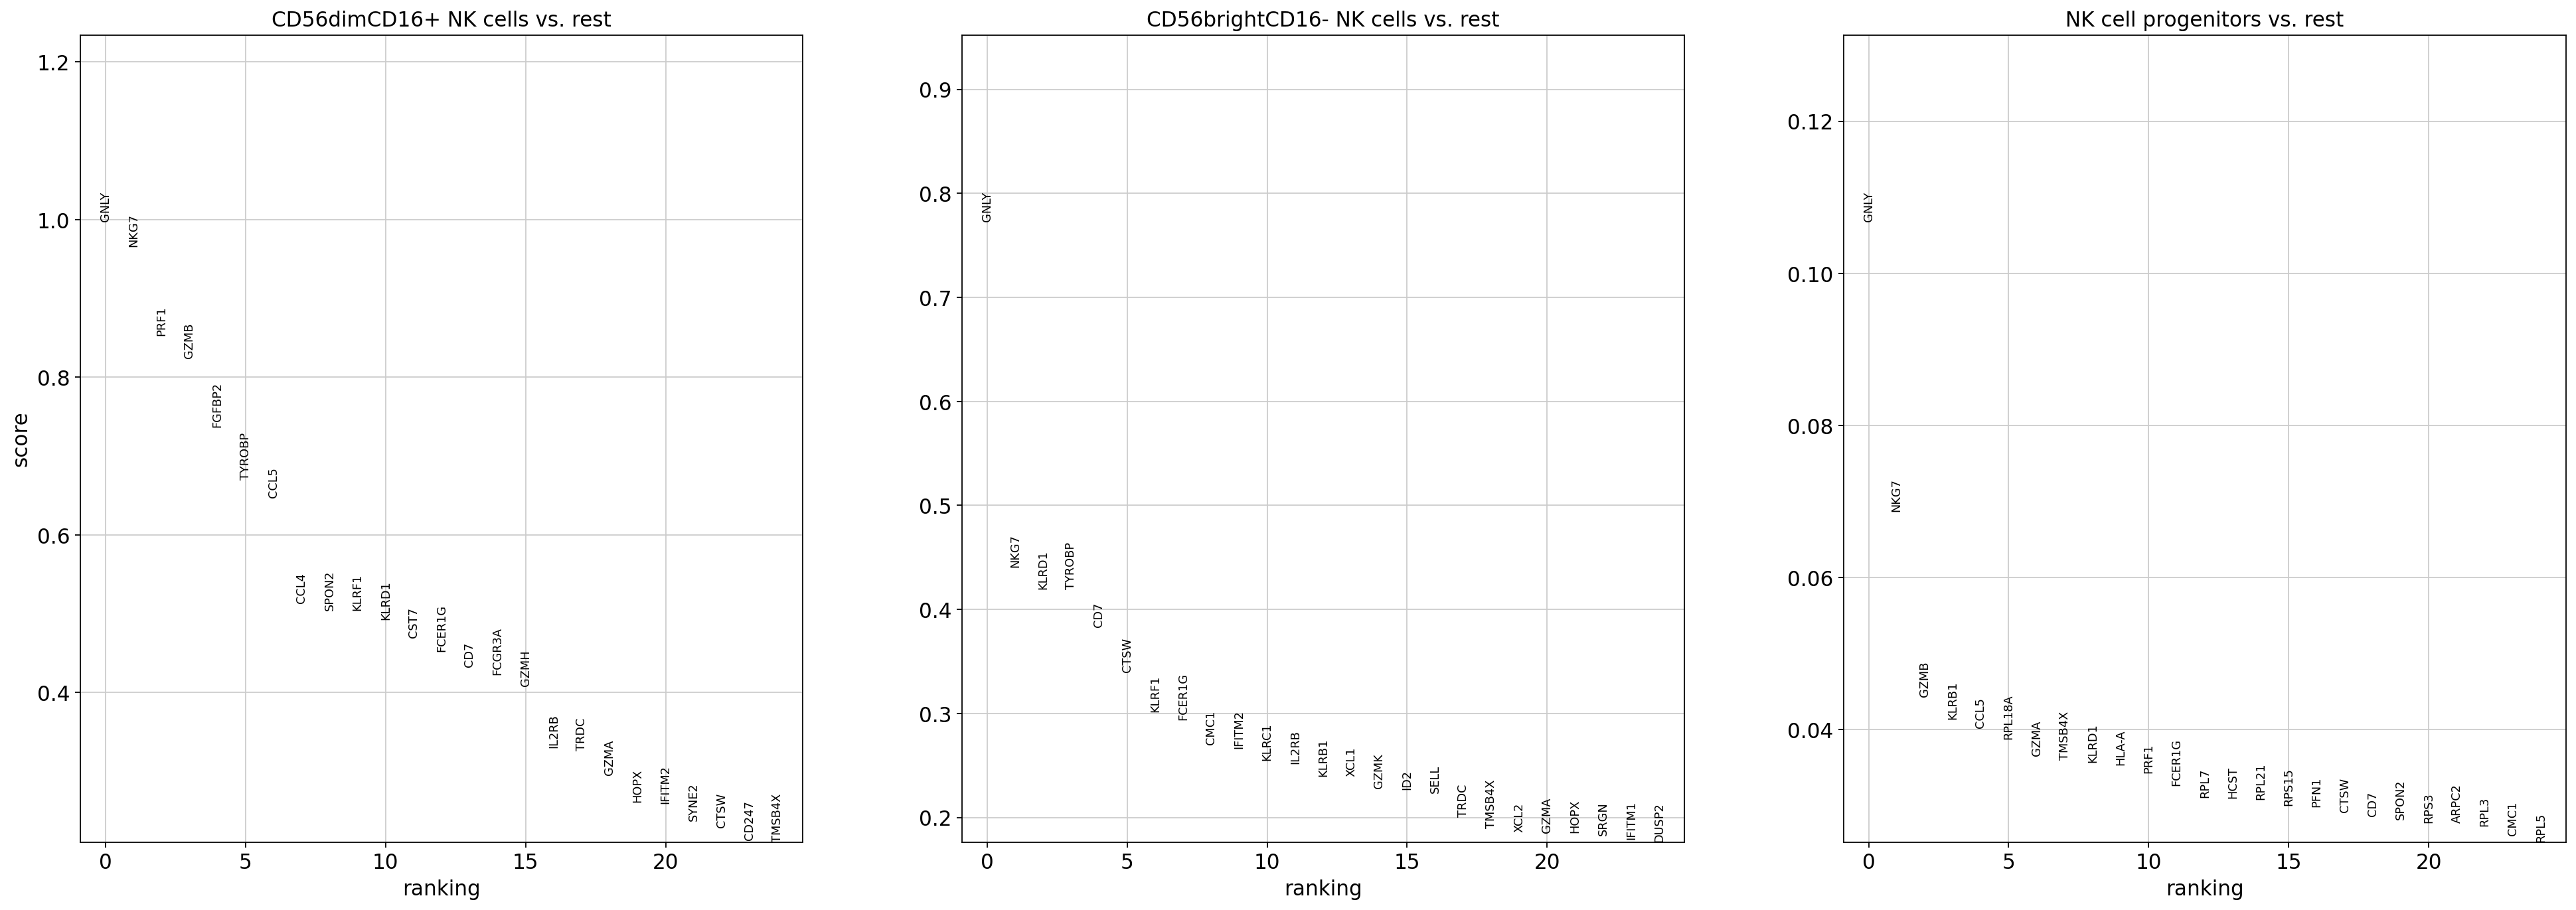

In [15]:
cells = ["CD56dimCD16+ NK cells", "CD56brightCD16- NK cells", "NK cell progenitors"]
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, groups=cells, save="NK_markers.png")

### B cells

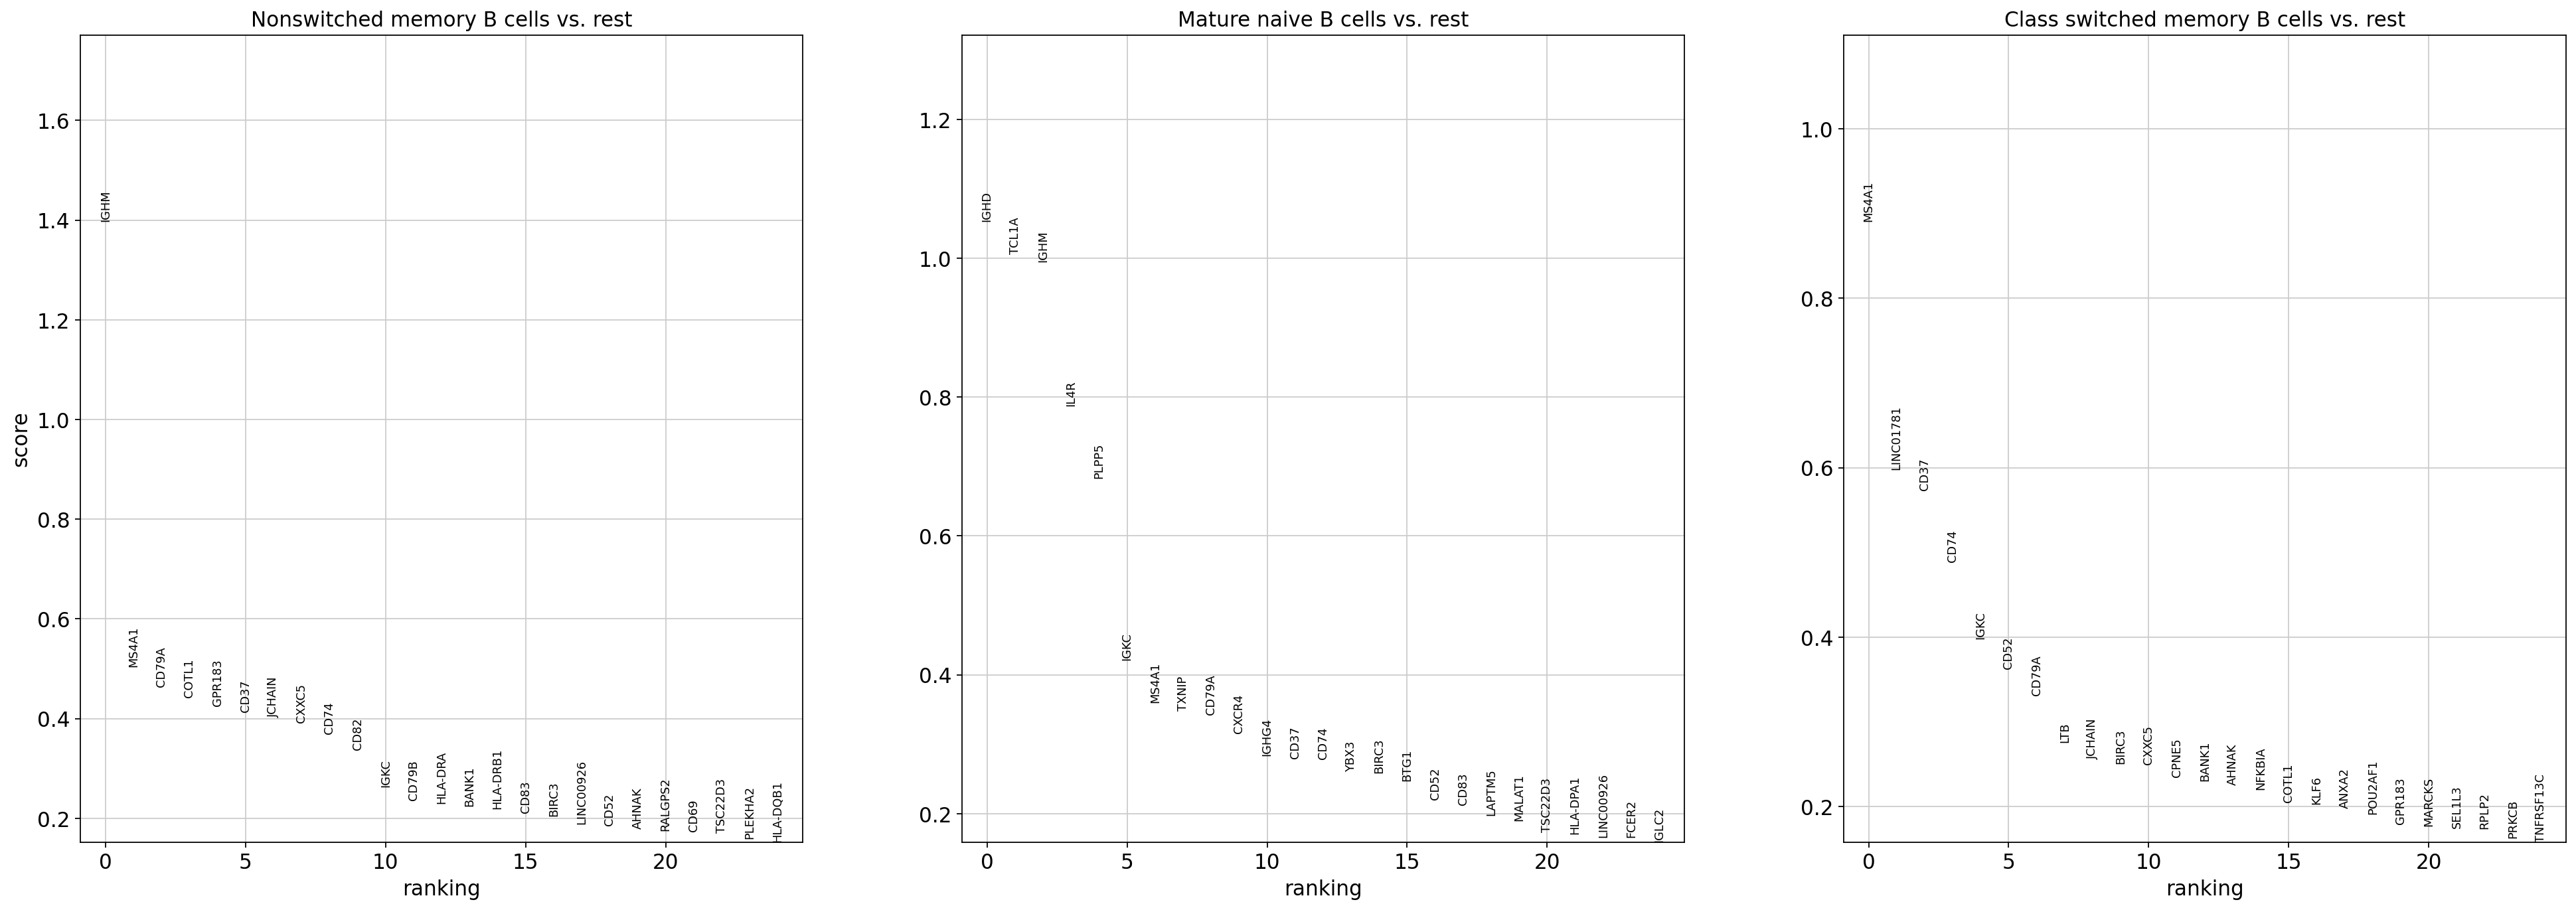

In [21]:
cells = ["Nonswitched memory B cells", "Mature naive B cells", "Class switched memory B cells"]
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, groups=cells, save="NK_markers.png")

### Plasma cells

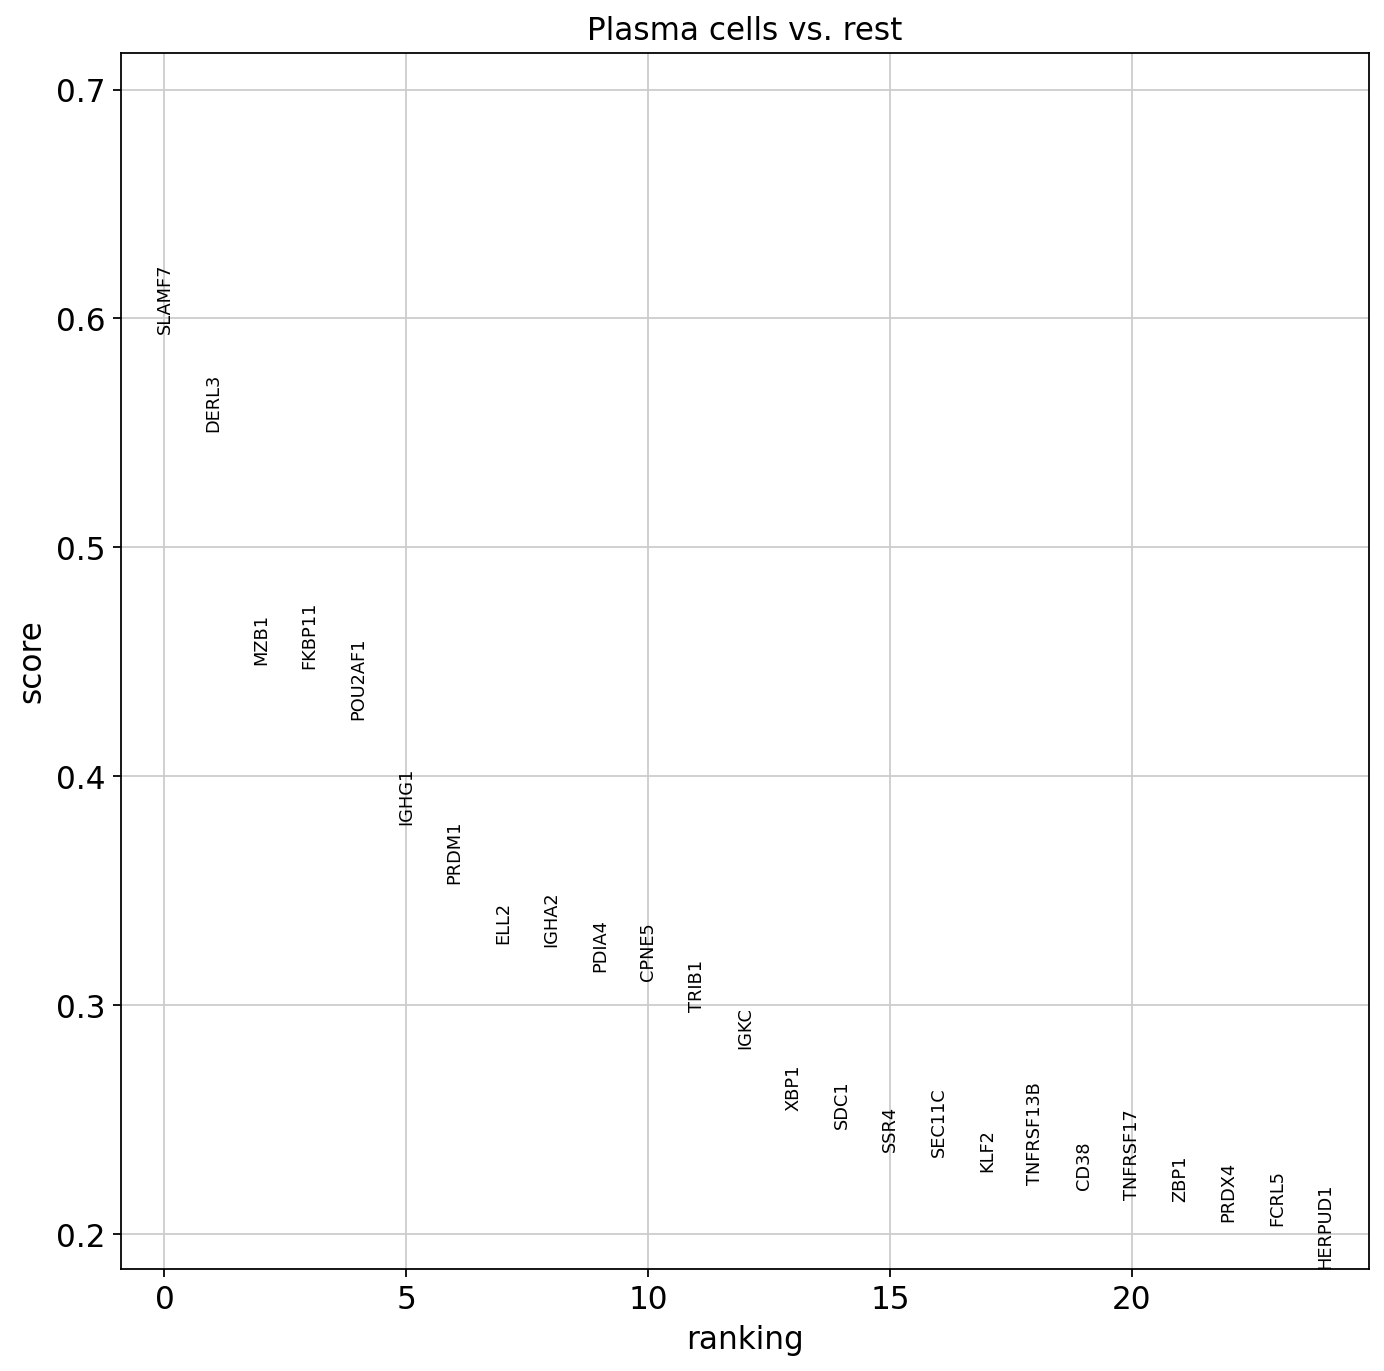

In [22]:
cells = ["Plasma cells"]
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, groups=cells, save="Plasma_markers.png")

# Conclusions

Markers are specific and no more refining are needed in the cell annotation